# TensorFlow Data Pipeline

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 05 - Deep Learning for Computer Vision/2- TensorFlow Data Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->



The Dataset API allows you to build an asynchronous, highly optimized data pipeline to prevent your GPU from data starvation. It loads data from the disk (images or text), applies optimized transformations, creates batches and sends it to the GPU. Former data pipelines made the GPU wait for the CPU to load the data, leading to performance issues.

The set of tools we'll go over are part of `tf.data` API, further details can be found here: https://www.tensorflow.org/guide/data

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The libraries below are built-into python and are used to work with local storage and directories
import os

In [ ]:
tf.random.set_seed(42)



## Basic Example

To create an input pipeline, you must start with a data source. For example, to construct a Dataset from data in memory, you can use `tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.

Once you have a Dataset object, you can transform it into a new Dataset by chaining method calls on the `Dataset` object. For example, you can apply per-element transformations such as `Dataset.map()`, and multi-element transformations such as `Dataset.batch()`.

The Dataset object is a Python iterable. This makes it possible to consume its elements using a for loop




First, we'll create a synthetic dataset of inputs and tagets, the dataset  has 100 samples and each sample has 5 features.

In [ ]:
x = tf.random.normal([1000, 5])
y = tf.random.uniform([1000])

Second, we'll use the `tf.data` API to create a `Dataset` object. Since we already have the input/target tensors ready, we'll use `from_tensor_slices` method to create the dataset.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x, y))

dataset = dataset.shuffle(
    100
)  # Shuffle the data, `100` represnts the buffer size, read the documentation for more details
dataset = dataset.batch(8)  # Create mini-batches for the specified size

In [ ]:
# dataset.take(1) gets the first batch from the dataset

for x, y in dataset.take(1):
    print(x)
    print(y)

tf.Tensor(
[[-2.0931823   0.8333428   0.8950591  -1.2866151  -0.66670054]
 [ 0.17054136  0.01288263  0.5330144   0.4290613  -1.4899148 ]
 [-0.1552207  -1.1783086   0.2993208   0.3055077   0.1879138 ]
 [ 1.3383418  -1.6600039   0.5864756  -0.44295436 -0.14115417]
 [-2.2489896   0.21912704  1.3117646   0.9054835  -0.90999335]
 [ 0.21639644 -0.97485447 -0.20757681 -0.03647729 -1.3353444 ]
 [ 0.6885855   1.1110833   0.40130252  0.6320586  -0.39030614]
 [ 1.4881696   0.32253137 -0.42753866 -0.43751335 -1.806356  ]], shape=(8, 5), dtype=float32)
tf.Tensor(
[0.4346044  0.14328372 0.8646754  0.84159875 0.75972784 0.26160395
 0.69734323 0.5044954 ], shape=(8,), dtype=float32)


## Data Pipeline with CIFAR10 Dataset


We'll create a TensorFlow Data Pipeline for CIFAR10 Dataset, we'll do the same loading and preprocessing steps as the last example.

### Load & Preprocess Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [ ]:
print("Target values before reshaping: ", y_train[0], y_test[0])

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print("Target values after reshaping: ", y_train[0], y_test[0])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

Target values before reshaping:  [6] [3]
Target values after reshaping:  6 3


((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

In [ ]:
# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert the labels to one hot vectors
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)

y_train[0], tf.argmax(y_train[0])

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>)

### Create TensorFlow Data Pipeline

Since we'll be creating two `tf.data` Datasets, we'll first define a function that creates the `Dataset` object for us.

In [ ]:
def dataset_creator(x, y, batch_size=32):
    """
    Create a tf.data.Dataset from input/target tensors
    """

    data = tf.data.Dataset.from_tensor_slices((x, y))

    data = data.shuffle(
        1024
    )  # Shuffle the data, `100` represnts the buffer size, read the documentation for more details
    data = data.batch(batch_size)  # Create mini-batches for the specified size

    # This allows later elements to be prepared while the current element is being processed.
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [ ]:
train_dataset = dataset_creator(x_train, y_train)  # Create training dataset
test_dataset = dataset_creator(x_test, y_test)  # Create testing dataset

### Build & Train Model
Now we'll build the same model from the last example and use the created datasets for training and validation

In [ ]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input((32, 32, 3)),
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [ ]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

Now here's the difference, instead of passing both x's and y's in the `fit` method and `validation_data` parameter, we'll just pass the dataset object.

In [ ]:
model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
1563/1563 [==============================] - 9s 4ms/step - loss: 1.6879 - accuracy: 0.3801 - val_loss: 1.1200 - val_accuracy: 0.6062
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0838 - accuracy: 0.6157 - val_loss: 0.9623 - val_accuracy: 0.6609
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8788 - accuracy: 0.6930 - val_loss: 0.8348 - val_accuracy: 0.7082
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7584 - accuracy: 0.7333 - val_loss: 0.8431 - val_accuracy: 0.7079
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6583 - accuracy: 0.7678 - val_loss: 0.8039 - val_accuracy: 0.7298
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.5863 - accuracy: 0.7912 - val_loss: 0.8024 - val_accuracy: 0.7424
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5180 - accuracy: 0.8178 - val_loss: 0.8958 - val_accura

## Data Augmentation

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

Augmenting image data includes applying transformations such as flipping, color modification, cropping, rotation, noise injection and random erasing, some of these operations are available in `tf.image` API, a comprehensive guide to the tools available in `tf.image` is available here: https://www.tensorflow.org/api_docs/python/tf/image

This example uses the CIFAR10 data from earlier example, make sure to run the "Load & Preprocess Data" from the previous section.

### Create TensorFlow Data Pipeline

Firstly, we'll create a function that takes in an image and apply the augmentation transformations. 

In [ ]:
def augment_image(image, label):
    """
    Takes in an image and label slice (x, y) and returns a transformed version for the image along with the same label to be used in training
    """
    image = tf.image.random_flip_left_right(
        image
    )  # Randomly flip an image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flips an image vertically
    image = tf.image.random_brightness(
        image, max_delta=32.0 / 255.0
    )  # Adjust the brightness of images by a random factor
    image = tf.image.random_saturation(
        image, lower=0.5, upper=1.5
    )  # Adjust the saturation of RGB images by a random factor

    # Make sure the image's pixel values are still between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

Next will create a slightly modified version of `dataset_creator` method that uses the `map` function to apply the augmentation transformations defined in `augment_image` function above.

We'll also add a `training` parameter to indicate whether this dataset is going to be used for training or validation, and only apply the transformation if `trainin=True` since we don't want to augment the testing/validation dataset.

In [ ]:
def augmented_dataset_creator(x, y, batch_size=32, training=False):
    """
    Create a tf.data.Dataset from input/target tensors
    """

    data = tf.data.Dataset.from_tensor_slices((x, y))

    if (
        training
    ):  # If training == True then apply train preprocess on dataset, this makes sure that the validation dataset isn't augmented
        data = data.map(
            augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )  # Applying the augment_image function on dataset

    data = data.shuffle(
        1024
    )  # Shuffle the data, `1024` represnts the buffer size, read the documentation for more details
    data = data.batch(batch_size)  # Create mini-batches for the specified size

    # This allows later elements to be prepared while the current element is being processed.
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [ ]:
train_dataset = augmented_dataset_creator(x_train, y_train, training=True)
test_dataset = augmented_dataset_creator(x_test, y_test)

In the cell below, we'll take a batch from the `train_dataset` and show 25 samples from them to see the effect of the transformations.

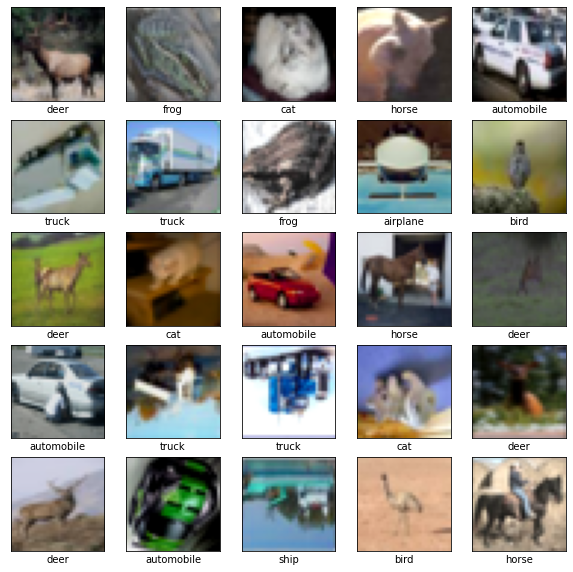

In [ ]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

for x, y in train_dataset.take(1):

    plt.figure(figsize=(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)  # Create a subplot on a 5x5 grid for index i

        plt.xticks([])  # Remove the ticks of the number line from the x axis
        plt.yticks([])  # Remove the ticks of the number line from the y axis

        plt.imshow(
            x[i]
        )  # Plot the image, no need to use the cmap parameter since this image is in RGB

        target_index = tf.argmax(
            y[i]
        )  # Convert the one-hot encoding to the original value
        plt.xlabel(class_names[target_index])  # Add the class name below the image

### Build & Train Model

In [ ]:
model_aug = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input((32, 32, 3)),
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

model_aug.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [ ]:
model_aug.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [ ]:
model_aug.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 1.8221 - accuracy: 0.3225 - val_loss: 1.3057 - val_accuracy: 0.5148
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2893 - accuracy: 0.5346 - val_loss: 1.1301 - val_accuracy: 0.5956
Epoch 3/10
1563/1563 [==============================] - 10s 7ms/step - loss: 1.1072 - accuracy: 0.6017 - val_loss: 1.0435 - val_accuracy: 0.6314
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9914 - accuracy: 0.6471 - val_loss: 1.0196 - val_accuracy: 0.6384
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9084 - accuracy: 0.6811 - val_loss: 0.9289 - val_accuracy: 0.6743
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8385 - accuracy: 0.7028 - val_loss: 0.9702 - val_accuracy: 0.6618
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7832 - accuracy: 0.7222 - val_loss: 0.9480 - val_ac

### Plot Training History

Let's compare the training graphs between the augmented and non-augmented version to see the effects of data augmentation on overfitting. 

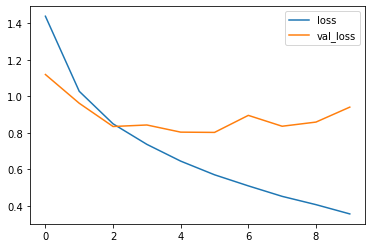

In [ ]:
# Non Augmented Version
pd.DataFrame(model.history.history)[["loss", "val_loss"]].plot.line()

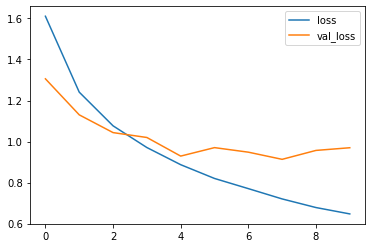

In [ ]:
# Augmented Version
pd.DataFrame(model_aug.history.history)[["loss", "val_loss"]].plot.line()

## Cats vs Dogs Example

In the last example, we'll download a dataset from the internet and manually create and x,y pairs from storage files and use them to create a `Dataset` object

### Download & Preprocess Data

First, we'll need to download and unzip the images, for that we'll be using the bang `!` keyword to run terminal commands, we'll use `wget` to download and `unzip` to extract files.

In [ ]:
!!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

['--2021-01-29 12:51:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
 'Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 108.177.119.128, 108.177.126.128, ...',
 'Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 68606236 (65M) [application/zip]',
 'Saving to: ‘cats_and_dogs_filtered.zip.1’',
 '',
 '',
 '          cats_and_   0%[                    ]       0  --.-KB/s               ',
 '         cats_and_d  24%[===>                ]  16.01M  20.6MB/s               ',
 '        cats_and_do  53%[=========>          ]  35.30M  36.1MB/s               ',
 '       cats_and_dog  73%[=============>      ]  48.01M  30.0MB/s               ',
 'cats_and_dogs_filte 100%[===================>]  65.43M  39.2MB/s    in 1.7s    ',
 '',
 '2021-01-29 12:51:27 (39.2 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]',
 '']

In [ ]:
!unzip cats_and_dogs_filtered.zip

This is how the dataset directory is laid out:

```
cats_and_dogs_filtered
└───train
│   └───cats
│   │   │   cat.0.jpg
│   │   │   cat.1.jpg
│   │   │   ...
│   └───dogs
│       │   dog.0.jpg
│       │   dog.1.jpg
│       │   ...
└───validation
│   └───cats
│   │   │   cat.2000.jpg
│   │   │   cat.2001.jpg
│   │   │   ...
│   └───dogs
│       │   dog.2000.jpg
│       │   dog.2001.jpg
│       │   ...
```

We'll create a function that takes in the path of either the train or validation folders, loops over the folders and files inside it, and finally return a tuple of the image paths and image labels (i.e. the x's and y's).

In [ ]:
def create_cats_vs_dogs_dataset_from_path(path):

    # Create the arrays that will hold the paths and labels
    image_paths = []
    image_labels = []

    # os.listdir returns an array of the files or directories in the specified path
    for dir in os.listdir(path):  # This loops over ['cats', 'dogs']
        for file in os.listdir(
            f"{path}/{dir}"
        ):  # This loops over all the images inside the directoy

            # Create the full path of the image
            image_path = f"{path}/{dir}/{file}"
            # Assign the label depending on the directory, 0 for cats and 1 for dogs
            image_label = 0 if dir == "cats" else 1

            # Append the image path and label to the arrays we defined earlier
            image_paths.append(image_path)
            image_labels.append(image_label)

    # Convert the arrays to Numpy arrays
    image_paths = np.array(image_paths)
    image_labels = np.array(image_labels)

    # Return the tuple
    return image_paths, image_labels

Now we'll use the function above to create the train and testing dataset by passing the path of the train and validation directories respectively.

In [ ]:
image_paths_train, labels_train = create_cats_vs_dogs_dataset_from_path(
    "/content/cats_and_dogs_filtered/train"
)
image_paths_test, labels_test = create_cats_vs_dogs_dataset_from_path(
    "/content/cats_and_dogs_filtered/validation"
)

image_paths_train.shape, labels_train.shape, image_paths_test.shape, labels_test.shape

((2000,), (2000,), (1000,), (1000,))

Let's take a look at a few samples from the data we created so far

In [ ]:
# We're splicing the middle of the numpy array to get both cats and dogs.
print("Training Image Paths:\n", image_paths_train[995:1005])
print("Training Image Labels:\n", labels_train[995:1005])

Training Image Paths:
 ['/content/cats_and_dogs_filtered/train/cats/cat.29.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.901.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.779.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.367.jpg'
 '/content/cats_and_dogs_filtered/train/cats/cat.581.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.382.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.435.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.73.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.69.jpg'
 '/content/cats_and_dogs_filtered/train/dogs/dog.764.jpg']
Training Image Labels:
 [0 0 0 0 0 1 1 1 1 1]


### Create TensorFlow Data Pipeline

Now we're going to define the functions that will be used to create the pipeline, we'll first start with a function that takes an image path and label pair and returns the image tensor and the same label 

In [ ]:
def get_image_tensor_from_path(image_path, label):

    image = tf.io.read_file(
        image_path
    )  # Read and output the entire contents of the input file.
    image = tf.image.decode_jpeg(
        image
    )  # Convert the content of the file to a 3D Tensor (height, width, color_channels).
    image = tf.image.convert_image_dtype(
        image, tf.float32
    )  # Convert the tensor values (i.e. pixel brightness) to floats between 0 and 1
    image = tf.image.resize(
        image, (224, 224)
    )  # Resize the image to a fixed square size of 224 by 224

    return image, label

Next we'll define the image augmentation function that will apply random transformations to the image

In [ ]:
# This is the same function that was defined in the CIFAR10 example


def augment_image(image, label):

    image = tf.image.random_flip_left_right(
        image
    )  # Randomly flip an image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flips an image vertically
    image = tf.image.random_brightness(
        image, max_delta=32.0 / 255.0
    )  # Adjust the brightness of images by a random factor
    image = tf.image.random_saturation(
        image, lower=0.5, upper=1.5
    )  # Adjust the saturation of RGB images by a random factor

    # Make sure the image's pixel values are still between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

And finally, the dataset creator function that will put everything together

In [ ]:
def cat_v_dog_dataset_creator(x, y, batch_size=32, training=False):

    data = tf.data.Dataset.from_tensor_slices((x, y))

    # Convert image paths to image tensors using get_image_tensor_from_path
    data = data.map(
        get_image_tensor_from_path, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )

    if (
        training
    ):  # If training == True then apply train preprocess on dataset, this makes sure that the validation dataset isn't augmented
        data = data.map(
            augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )  # Applying the augment_image function on dataset

    data = data.shuffle(
        2000
    )  # Shuffle the data, `2000` represnts the buffer size, read the documentation for more details
    data = data.batch(batch_size)  # Create mini-batches for the specified size

    # This allows later elements to be prepared while the current element is being processed.
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [ ]:
train_dataset = cat_v_dog_dataset_creator(
    image_paths_train, labels_train, training=True
)
test_dataset = cat_v_dog_dataset_creator(image_paths_test, labels_test)

In the cell below, we'll take a batch from the `train_dataset` and show 25 samples from them to see the effect of the transformations.

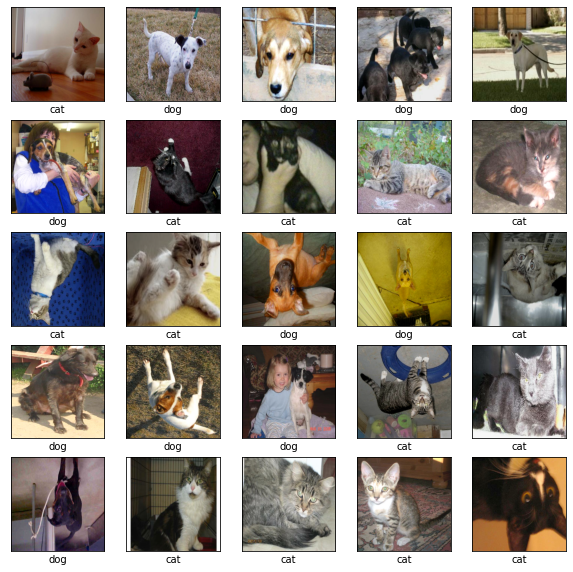

In [ ]:
class_names = ["cat", "dog"]

for x, y in train_dataset.take(1):

    plt.figure(figsize=(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)  # Create a subplot on a 5x5 grid for index i

        plt.xticks([])  # Remove the ticks of the number line from the x axis
        plt.yticks([])  # Remove the ticks of the number line from the y axis

        plt.imshow(
            x[i]
        )  # Plot the image, no need to use the cmap parameter since this image is in RGB

        plt.xlabel(class_names[y[i]])  # Add the class name below the image

### Build & Train Model

For this example, the `Input` layer's shape will be `(224, 224, 3)` representing the shape of each image in our dataset. As for the output, since we're dealing with only two classes (i.e. binomial classification), we'll use a single neuron in the output layer with `sigmoid` activation function.

In [ ]:
model_cat_v_dog = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input((224, 224, 3)),
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(512, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model_cat_v_dog.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 256)      

For compiling, we'll still use `Adam` optimizer, but since this is a binomial classification, we'll be using `BinaryCrossentropy()` instead of `CategoricalCrossentropy()`.

In [ ]:
model_cat_v_dog.compile(
    optimizer="adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"]
)

And finally we'll fit the model over 20 epoches.

In [ ]:
model_cat_v_dog.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
63/63 [==============================] - 9s 59ms/step - loss: 0.7439 - accuracy: 0.4763 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
63/63 [==============================] - 8s 57ms/step - loss: 0.6933 - accuracy: 0.4858 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
63/63 [==============================] - 8s 57ms/step - loss: 0.6927 - accuracy: 0.5207 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/20
63/63 [==============================] - 8s 56ms/step - loss: 0.6930 - accuracy: 0.4988 - val_loss: 0.6917 - val_accuracy: 0.6150
Epoch 5/20
63/63 [==============================] - 8s 57ms/step - loss: 0.6938 - accuracy: 0.5115 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 6/20
63/63 [==============================] - 8s 56ms/step - loss: 0.6939 - accuracy: 0.5075 - val_loss: 0.6909 - val_accuracy: 0.5200
Epoch 7/20
63/63 [==============================] - 8s 56ms/step - loss: 0.6900 - accuracy: 0.5031 - val_loss: 0.6855 - val_accuracy: 0.5810
Epoch 8/20
63

### Plot Training History

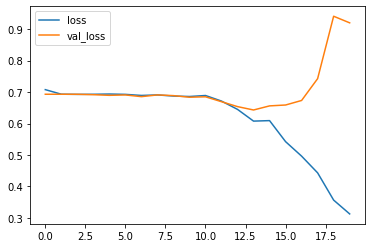

In [ ]:
pd.DataFrame(model_cat_v_dog.history.history)[["loss", "val_loss"]].plot.line()

There's some overfitting happening after ~12th epoch, this can be resolved by implementing early stopping or modifying the model's architecture.